In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Necessary Libraries

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
import seaborn as sns
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
print(os.listdir("/content/drive/My Drive/DRD/dataset"))
base_dir = "/content/drive/My Drive/DRD/dataset"

['GoogleNews-vectors-negative300.bin.gz', 'test.csv', 'train.csv', 'valid.csv', 'val_images', 'train_images', 'test_images']


In [3]:
train_csv = pd.read_csv('/content/drive/My Drive/DRD/dataset/train.csv')
test_csv = pd.read_csv('/content/drive/My Drive/DRD/dataset/test.csv')

In [4]:
print('Train Size = {}'.format(len(train_csv)))
print('Test Size = {}'.format(len(test_csv)))

Train Size = 2930
Test Size = 366


In [5]:
train_csv.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


<ipython-input-6-b438f353f7f6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')


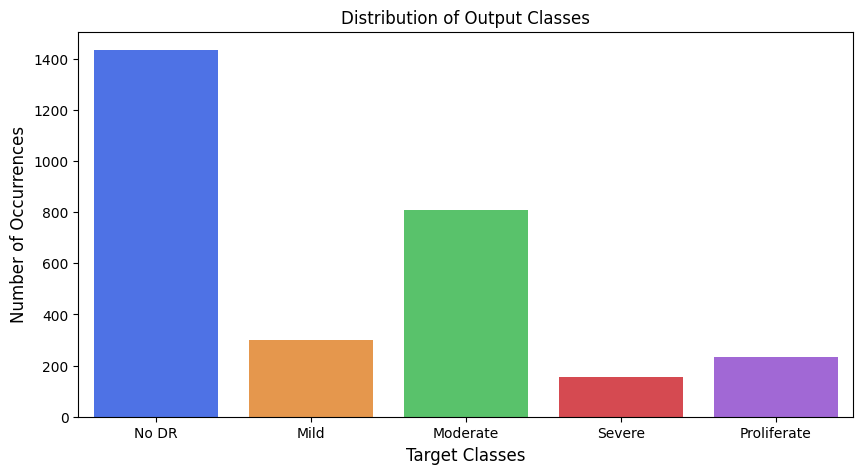

In [6]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

Visualizing Training Set

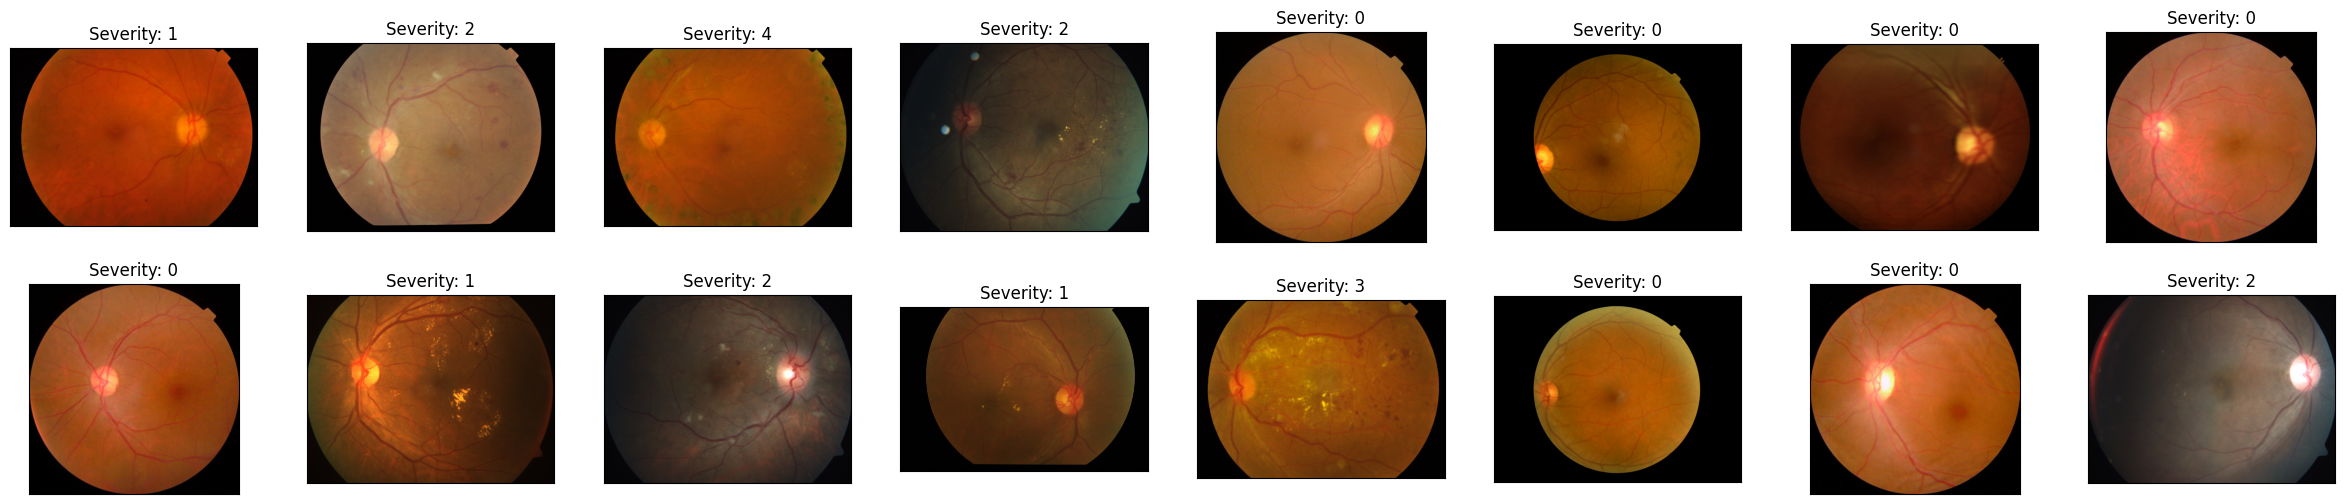

In [7]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

Visualizing Test Set

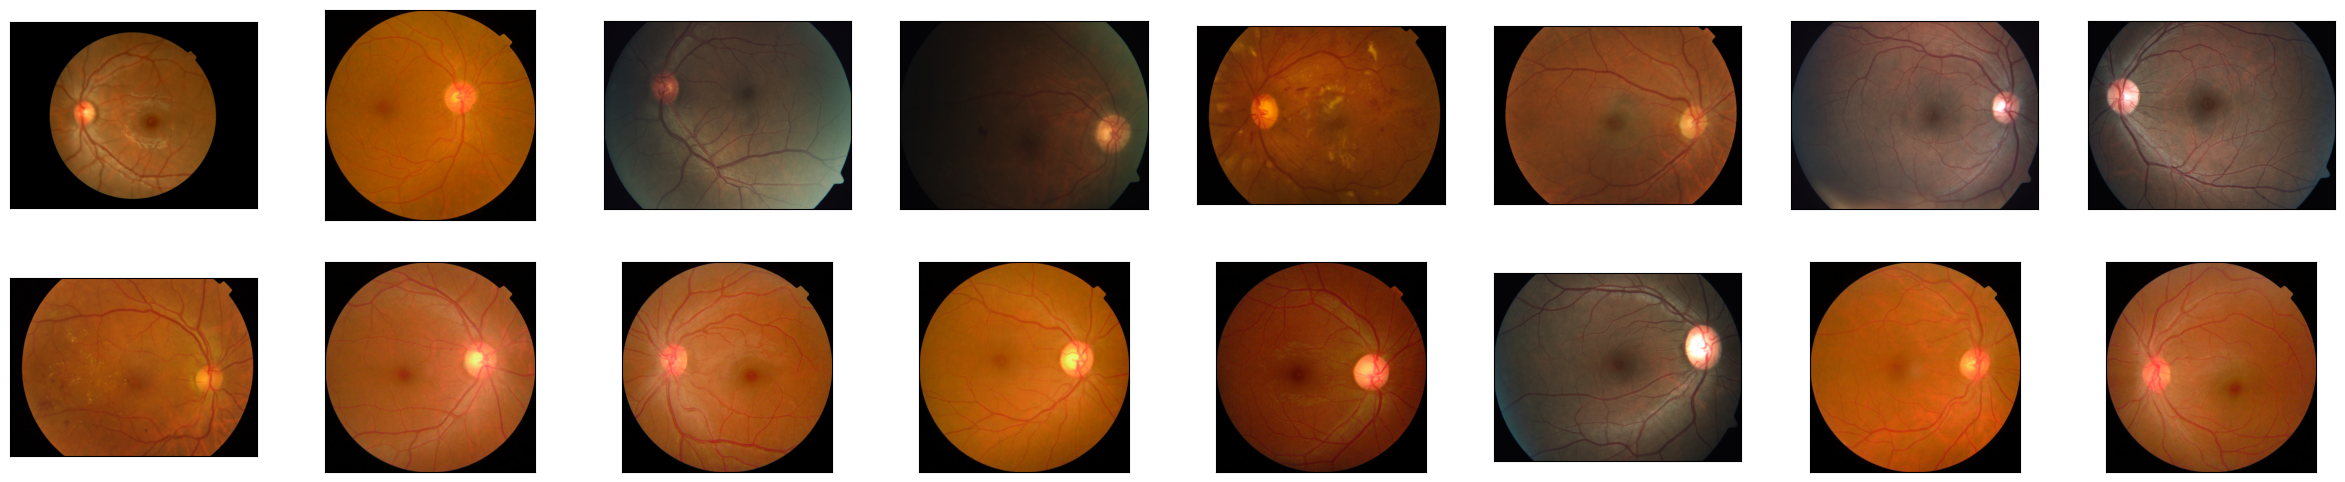

In [8]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

Data Processing

In [9]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '/content/drive/My Drive/DRD/dataset', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [10]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [11]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [12]:
train_path = "/content/drive/My Drive/DRD/dataset/train_images/"
test_path = "/content/drive/My Drive/DRD/dataset/test_images/"

In [13]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [14]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [15]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [16]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [17]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 2930
testing examples contain : 366
37
10
6


In [18]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([0, 2, 0, 0, 0, 0, 3, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 3, 3, 0, 0, 0, 1,
        2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 3, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0, 0, 3,
        0, 0, 2, 0, 0, 4, 0, 2, 0, 0, 0, 4, 0, 0, 2, 0])


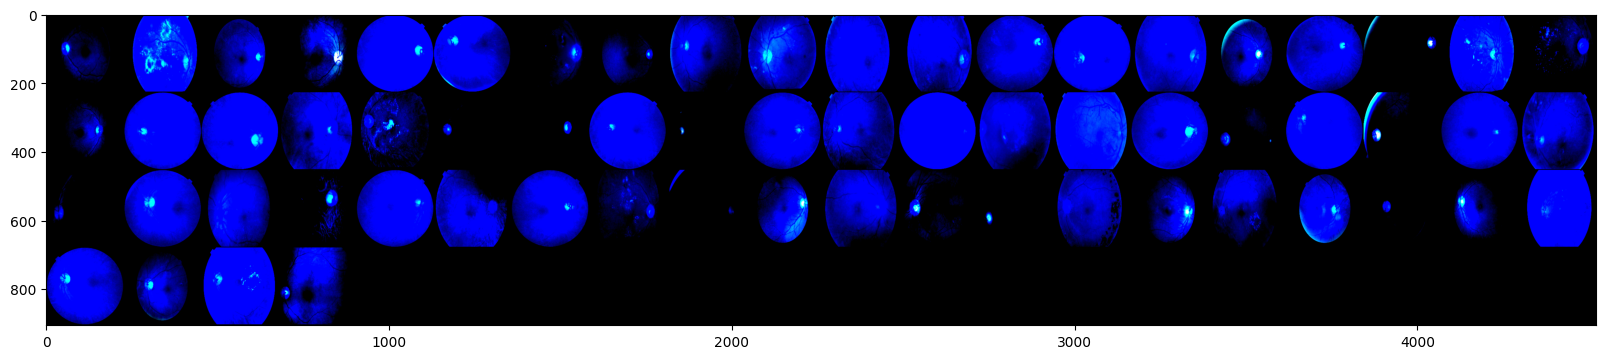

In [19]:
# plotting the images of loaded batch with given fig size and frame data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print('labels:', labels)

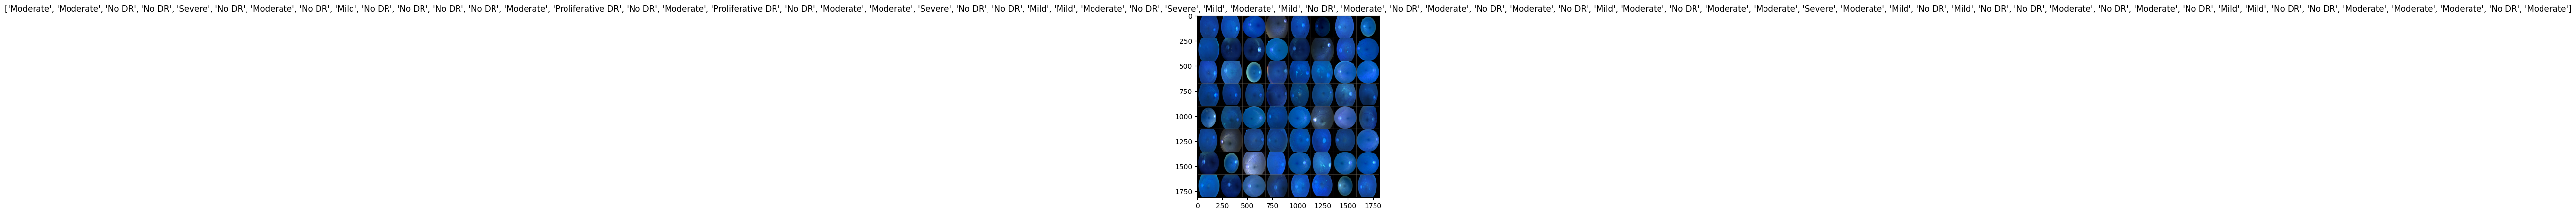

In [20]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [21]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

num_ftrs = model.fc.in_features
out_ftrs = 5

model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 179MB/s]


In [23]:
model_save_name = 'classifier.pt'
path = "/content/drive/My Drive/DRD/" + model_save_name

In [24]:
# to unfreeze more layers
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [25]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [26]:
def load_model(path):
  checkpoint = torch.load(path,weights_only=False)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [27]:
model = load_model("/content/drive/My Drive/DRD/classifier.pt")

In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [30]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.inf
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval()
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images)
          test_loss += criterion(logps,labels)
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train()
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader)))
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)
    print('Training Completed Succesfully !')
    return train_losses, test_losses, acc

In [31]:
train_losses, valid_losses, acc = train_and_test(5)

Model Training started.....
 epoch 1 batch 10 completed
 epoch 1 batch 20 completed
 epoch 1 batch 30 completed
validation started for 1
Epoch: 1/5..  Training Loss: 0.086..  Valid Loss: 0.060..  Valid Accuracy: 0.986
Validation loss decreased (inf --> 0.060323).  Saving model ...
 epoch 2 batch 10 completed
 epoch 2 batch 20 completed
 epoch 2 batch 30 completed
validation started for 2
Epoch: 2/5..  Training Loss: 0.086..  Valid Loss: 0.053..  Valid Accuracy: 0.989
Validation loss decreased (0.060323 --> 0.052571).  Saving model ...
 epoch 3 batch 10 completed
 epoch 3 batch 20 completed
 epoch 3 batch 30 completed
validation started for 3
Epoch: 3/5..  Training Loss: 0.091..  Valid Loss: 0.051..  Valid Accuracy: 0.989
Validation loss decreased (0.052571 --> 0.050942).  Saving model ...
 epoch 4 batch 10 completed
 epoch 4 batch 20 completed
 epoch 4 batch 30 completed
validation started for 4
Epoch: 4/5..  Training Loss: 0.088..  Valid Loss: 0.055..  Valid Accuracy: 0.991
 epoch 5 b

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import numpy as np

def evaluate_model():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

            ps = torch.exp(outputs)
            _, predicted = ps.topk(1, dim=1)
            predicted = predicted.view(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = test_loss / len(validloader)
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [33]:
evaluate_model()

Validation Loss: 0.0613
Accuracy: 0.9829
Precision: 0.9835
Recall: 0.9829
F1 Score: 0.9830


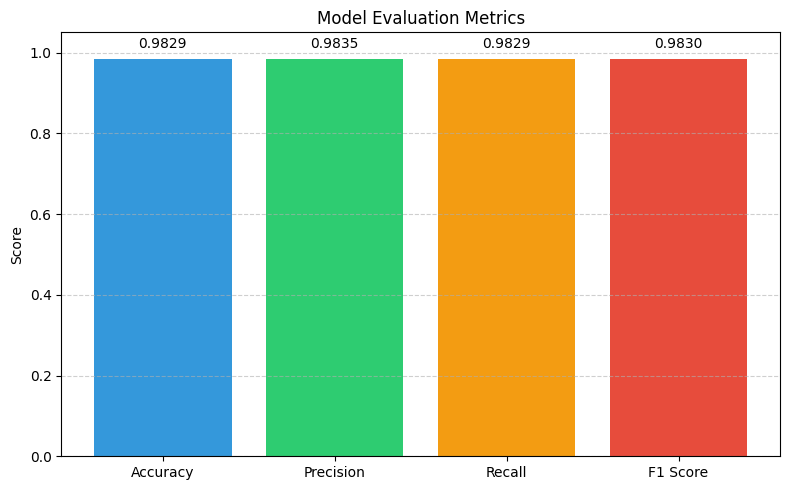

In [36]:
import matplotlib.pyplot as plt

# Replace these with the values printed from `evaluate_model()` if you're running separately
accuracy = 0.9829
precision = 0.9835
recall = 0.9829
f1 = 0.9830

# Plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
plt.ylim(0, 1.05)
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

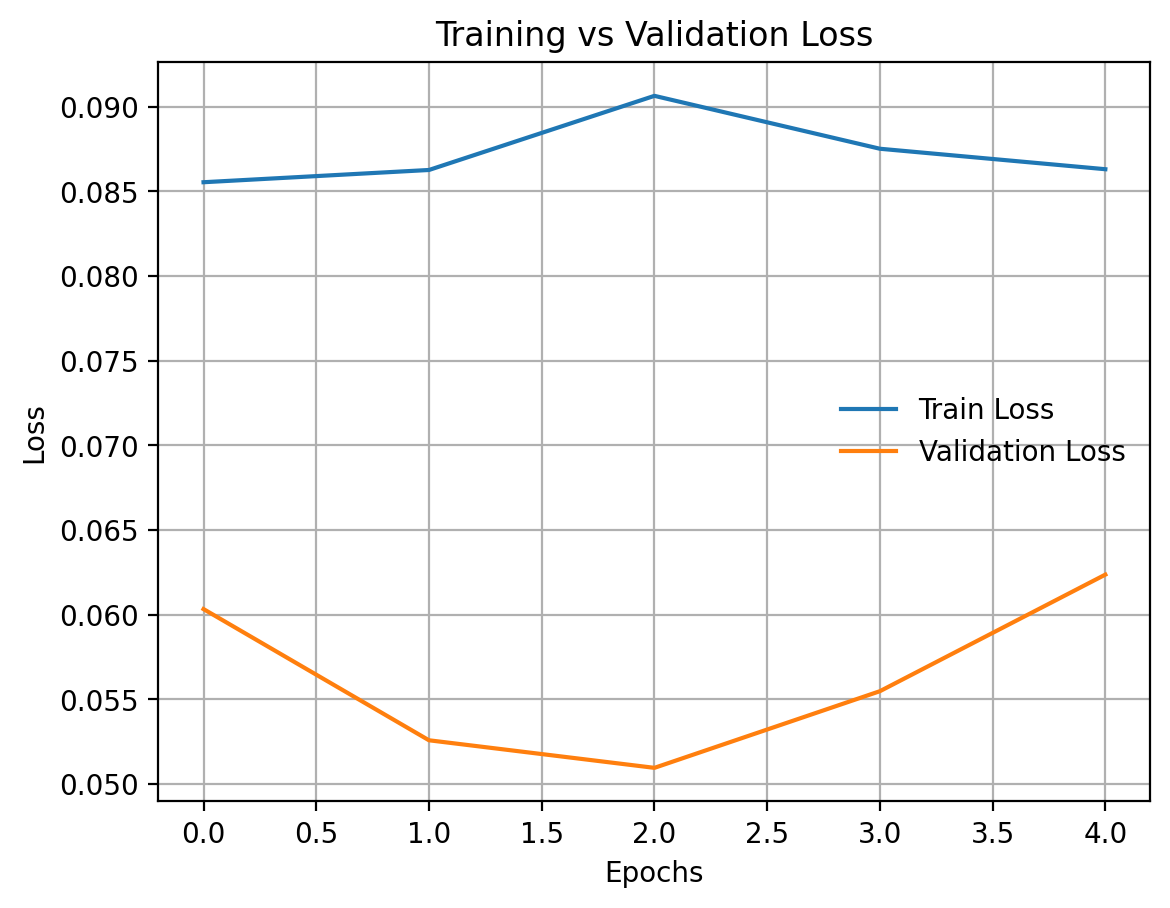

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Move tensors to CPU and convert to numpy
train_losses_np = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
valid_losses_np = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in valid_losses]

# Plotting
plt.plot(train_losses_np, label='Train Loss')
plt.plot(valid_losses_np, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.show()

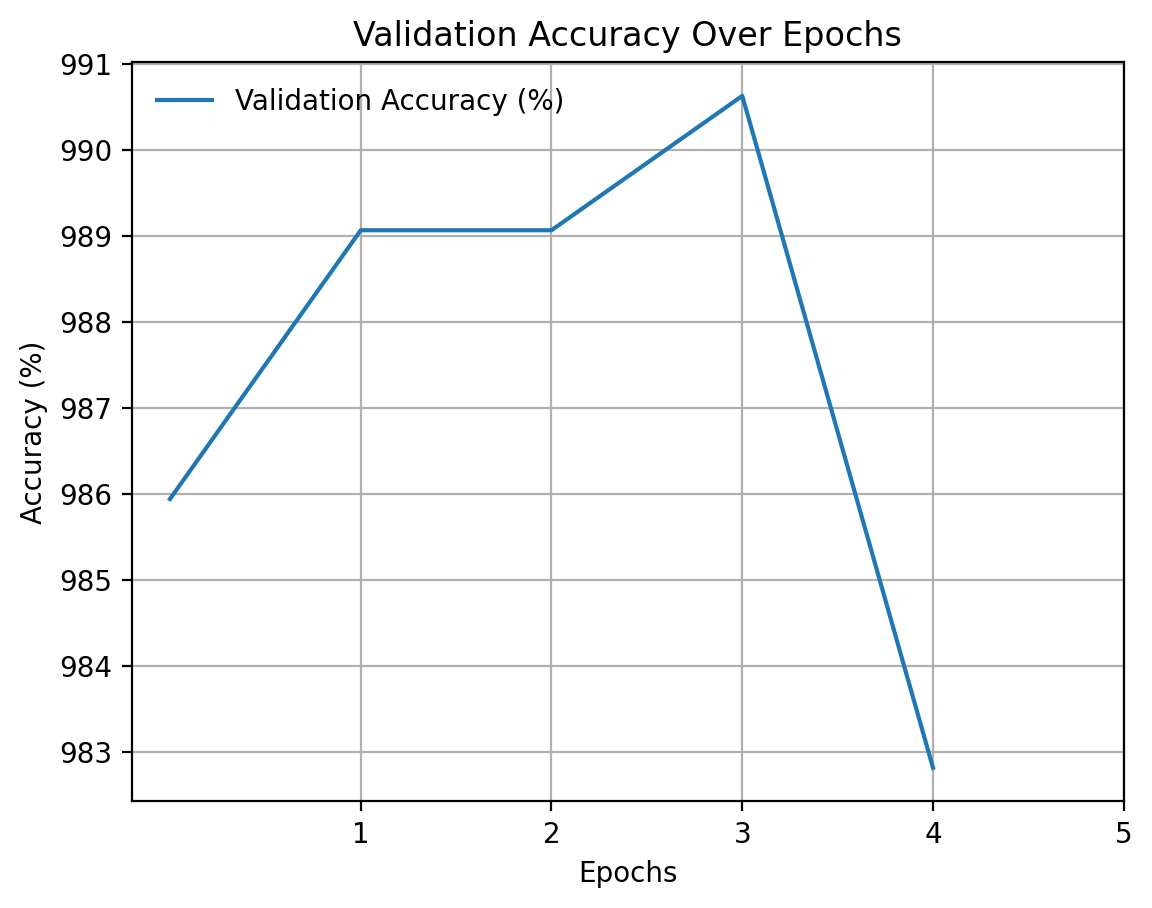

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot([a * 100 for a in acc], label='Validation Accuracy (%)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.legend(frameon=False)
plt.grid(True)
plt.xticks(ticks=range(1, len(acc) + 1))
plt.show()

Generating confusion matrix...


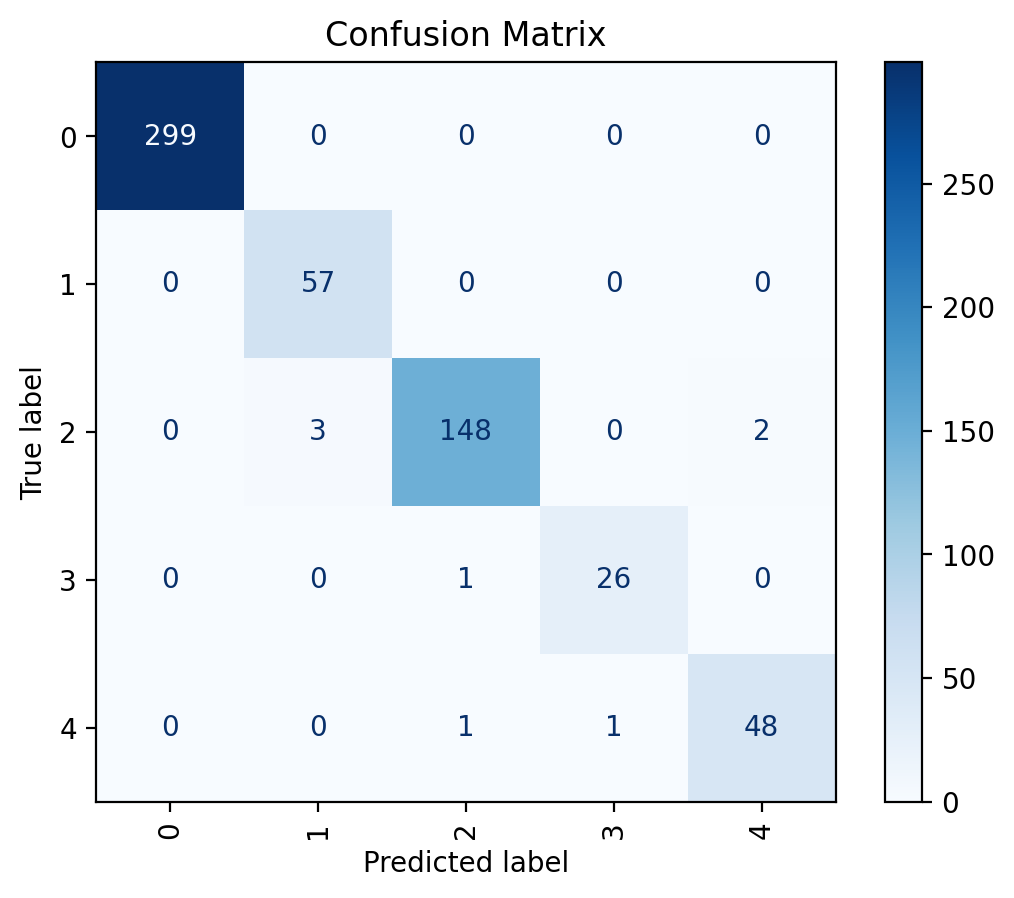

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix():
    print("Generating confusion matrix...")  # Confirm function runs
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            ps = torch.exp(outputs)
            _, predicted = ps.topk(1, dim=1)
            predicted = predicted.view(-1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

# Call the function
plot_confusion_matrix()

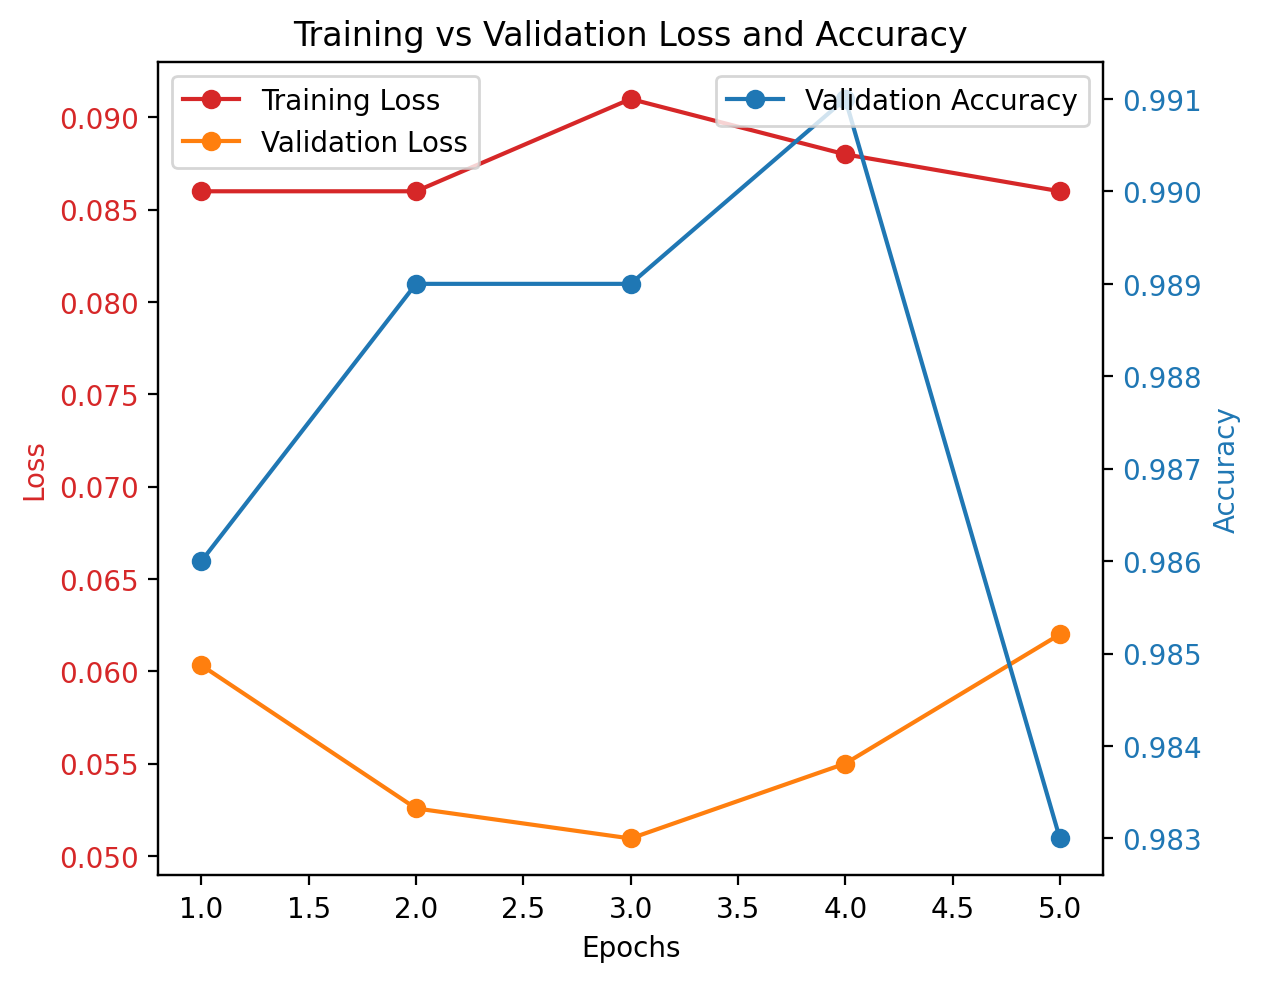

In [51]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3, 4, 5]

# Training and Validation Metrics
training_loss = [0.086, 0.086, 0.091, 0.088, 0.086]
validation_loss = [0.060323, 0.052571, 0.050942, 0.055, 0.062]
validation_accuracy = [0.986, 0.989, 0.989, 0.991, 0.983]

# Create the figure and primary y-axis for Loss
fig, ax1 = plt.subplots()

# Plot Training and Validation Loss
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, training_loss, label='Training Loss', color='tab:red', marker='o')
ax1.plot(epochs, validation_loss, label='Validation Loss', color='tab:orange', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(epochs, validation_accuracy, label='Validation Accuracy', color='tab:blue', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Legends and Title
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Training vs Validation Loss and Accuracy')

# Display the plot
plt.show()